In [1]:
import os

import numpy as np                         
import xarray as xr
import nc_time_axis

import glob

import matplotlib.pyplot as plt 

In [2]:
path = '/home/innag3580/phase1_CONDA/'

# Load data events and their temporal location
data = np.genfromtxt(path+'current/events_dens_spg.csv', delimiter=',', names=True, dtype=None)

# Accessing columns by name
member_numbers = data['Index']
events = data['Values']
member_names = np.zeros(len(member_numbers))

# set periods
before = 50*12 #!!!! for cummulative integration
after = 20*12

# find file names 
def find_corresponding_file_name(vvel_number_to_find):
    with open(path+'timeseries/order.txt', 'r') as file:
        vvel_list = file.readlines()
    vvel_dict = {filename.split()[1]: int(filename.split()[0]) for filename in vvel_list}
    vvel_filename = None
    for filename in vvel_list:
        if vvel_dict[filename.split()[1]] == vvel_number_to_find:
            vvel_filename = filename.split()[1]  
            break
    return vvel_filename

In [3]:
events

array([120, 105,  64, 141,  40,  56,  55, 121,  79,  41, 107,  57,  56])

# Choose time average

Annual mean

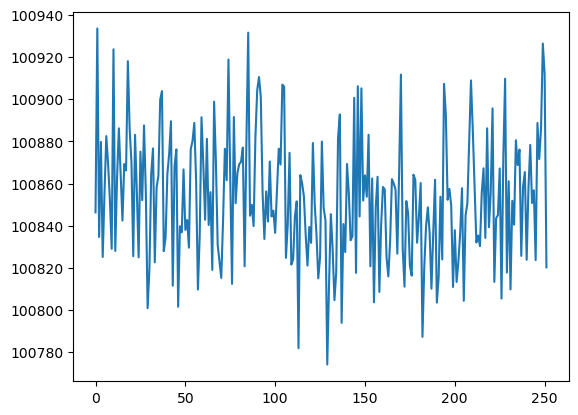

In [4]:
psl_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/psl/psl_1301.019.nc'
ds = xr.open_dataset(psl_file)#.isel(time=slice(0,100))
ds = ds.resample(time='A').mean(dim='time')
annual_mean = ds.PSL.mean(dim=['lat', 'lon']).values

plt.plot(annual_mean)

Winter Mean

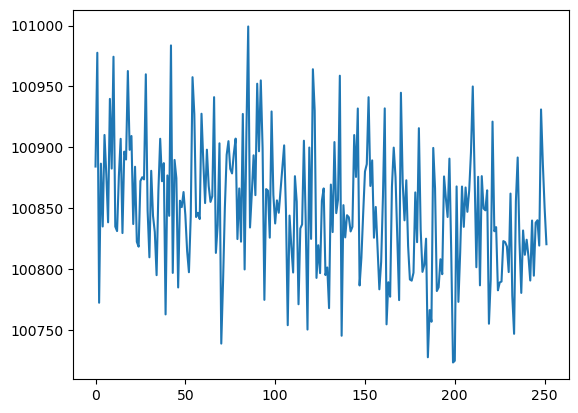

In [5]:
psl_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/psl/psl_1301.019.nc'
ds_winter = xr.open_dataset(psl_file)#.isel(time=slice(0,100))
monthly_average = ds_winter.sel(time=((ds_winter['time.month'] == 12) | (ds_winter['time.month'] == 1) | (ds_winter['time.month'] == 2))).resample(time='A').mean(dim='time')
winter_mean = monthly_average.PSL.mean(dim=['lat', 'lon']).values

plt.plot(winter_mean)


To compute annual mean: `mean = annual`?

To compute winter mean: `mean = winter`

In [6]:
mean = 'winter'

# SELECT TIME RANGE

In [7]:
for i in range(0, len(member_numbers)):
    # define entire time range for event
    member = find_corresponding_file_name(member_numbers[i])[5:]
    
    # Check if there are enough time steps for 'before', else set it to the maximum available
    if events[i] >= 50:
        before = 50*12
    else:
        before = events[i]*12
    
    event = events[i]*12
    period_start = event-before
    period_end = event+after
    
    print('computation member '+member+' started')

    # select time range in data arrays
    time = slice(period_start, period_end)

    # open files and take annual means 
    psl_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/psl/psl_'+member
    
    if mean == 'annual':
    
        ds = xr.open_dataset(psl_file).isel(time=time).resample(time='A').mean(dim='time')
        if 'time_bound' in ds.variables:
            ds = ds.drop_vars('time_bound')

        # save array
        ds.to_netcdf('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/psl_composite_'+member)
        
    elif mean == 'winter':
        
        ds_winter = xr.open_dataset(psl_file).isel(time=time)
        ds_winter = ds_winter.sel(time=((ds_winter['time.month'] == 12) | (ds_winter['time.month'] == 1) | (ds_winter['time.month'] == 2))).resample(time='A').mean(dim='time')

        if 'time_bound' in ds.variables:
            ds_winter = ds_winter.drop_vars('time_bound')

        ds_winter.to_netcdf('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/DJF_psl_composite_'+member)
    
    print(member+' saved')

computation member 1301.019.nc started
1301.019.nc saved
computation member 1231.001.nc started
1231.001.nc saved
computation member 1281.012.nc started
1281.012.nc saved
computation member 1301.001.nc started
1301.001.nc saved
computation member 1281.017.nc started
1281.017.nc saved
computation member 1231.020.nc started
1231.020.nc saved
computation member 1231.004.nc started
1231.004.nc saved
computation member 1281.010.nc started
1281.010.nc saved
computation member 1281.020.nc started
1281.020.nc saved
computation member 1301.015.nc started
1301.015.nc saved
computation member 1281.015.nc started
1281.015.nc saved
computation member 1231.003.nc started
1231.003.nc saved
computation member 1251.010.nc started
1251.010.nc saved


# COMPUTE 60 YEAR ANNUAL COMPOSITES

In [10]:
if mean == 'annual':
    psl_files = sorted(glob.glob('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/psl_composite_*.nc'))
elif mean == 'winter':
    psl_files = sorted(glob.glob('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/DJF_psl_composite_*.nc'))

In [11]:
var_years = []
for t in range(60):
    var_year = []
    for i in range(len(psl_files)):
        try:
            ds = xr.open_dataset(psl_files[i])
        except ValueError as e:
            continue

        ds_file = ds['PSL'].isel(time=t)
        var_year.append(ds_file)

    ds_comp = xr.concat(var_year, dim='file').mean(dim='file')
    var_years.append(ds_comp)

ds_var_annual = xr.concat(var_years, dim='time')

if mean == 'annual':
    ds_var_annual.to_netcdf('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/PSLcomposite.nc')
elif mean == 'winter':
    ds_var_annual.to_netcdf('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/DJF_PSLcomposite.nc')

# PERIOD COMPOSITES

In [12]:
psl_anomalies  = []

for i in range(len(psl_files)):
    try:
        ds = xr.open_dataset(psl_files[i])
        print(f"{psl_files[i]} exists")
        # Do further processing with the dataset 'ds' if needed
    except ValueError as e:
        print(f"Error opening dataset from file {files[i]}: {e}")
        # Handle the exception, for example, continue with the next file
        continue
    
    # TEMP
    period1_avg = ds['PSL'].isel(time=slice(0,35)).mean(dim='time')  
    period2_avg = ds['PSL'].isel(time=slice(45,59)).mean(dim='time')
    difference = period2_avg - period1_avg
    psl_anomalies.append(difference)

psl_anomaly = xr.concat(psl_anomalies, dim='file').mean(dim='file')


if mean == 'annual':
    psl_anomaly.to_netcdf(os.path.expanduser('~/phase1_CONDA/')+'/results/composites/psl_anomaly.nc')
elif mean == 'winter':
    psl_anomaly.to_netcdf(os.path.expanduser('~/phase1_CONDA/')+'/results/composites/DJF_psl_anomaly.nc')

/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/DJF_psl_composite_1231.001.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/DJF_psl_composite_1231.003.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/DJF_psl_composite_1231.004.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/DJF_psl_composite_1231.020.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/DJF_psl_composite_1251.010.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/DJF_psl_composite_1281.010.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/DJF_psl_composite_1281.012.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/DJF_psl_composite_1281.015.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/DJF_psl_composite_1281.017.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/DJF_psl_composite_1281.020.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/DJF_psl_composite_1301.00